In [304]:
import pandas as pd
import numpy as np
import scipy as sc
import datetime

import matplotlib.pyplot as plt
from scipy import stats
import gc

import warnings
from itertools import product

### Definitions

возьмите только те, которые были отобраны на второй неделе: means that only cells with non zero 

#### 0. Data Prep (reviewer shall not execute it)

In [2]:
#lets take may-16 drives and borders
borders = pd.read_csv('regions.csv', sep = ';', header =0)

In [3]:
borders.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [68]:
dt = pd.read_csv('yellow_tripdata_2016-05.csv', sep = ',', header = 0)

In [69]:
dt.columns

Index([u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'RatecodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount'],
      dtype='object')

In [6]:
dt.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [7]:
def hours_only(ts):
    t = pd.DataFrame({'Year': ts.dt.year
                  ,'Month':ts.dt.month
                  ,'Day':ts.dt.day
                  ,'Hour':ts.dt.hour })
    return(pd.to_datetime(t))

# initial (week 1) data cleaning
long_borders = [borders.west.min().tolist(), borders.east.max().tolist()]
lat_borders  = [borders.south.min().tolist(), borders.north.max().tolist()]

def basic_data_cleaning_and_new_features_wk1(dt):
    #Отбросьте минуты и секунды во времени начала поездки.
    dt['tpep_pickup_datetime'] = pd.to_datetime(dt['tpep_pickup_datetime'])
    dt['tpep_dropoff_datetime'] = pd.to_datetime(dt['tpep_dropoff_datetime'])

    
    #simple approach under assumption that NYC is actually a square
    dt['is_in_NYC'] = 0
    
    dt['tpep_pickup_datetime_short'] = hours_only(dt['tpep_pickup_datetime'])
    dt['tpep_dropoff_datetime_short'] = hours_only(dt['tpep_dropoff_datetime'])
    
    dt.loc[(dt.pickup_longitude >= long_borders[0])
            & (dt.pickup_longitude <= long_borders[1])
            & (dt.pickup_latitude >= lat_borders[0])
            & (dt.pickup_latitude <= lat_borders[1])
        ,'is_in_NYC'] = 1
    
    ### cleaning
    return(dt.loc[(dt.is_in_NYC == 1)
                        & (dt.trip_distance > 0)
                        & (dt.passenger_count > 0)
                        & ~(dt.tpep_pickup_datetime == dt.tpep_dropoff_datetime)])

dt_cl = basic_data_cleaning_and_new_features_wk1(dt)

In [8]:
#check with previous week
print 'Cleaned shape: ', dt_cl.shape
print 'Initial shape: ', dt.shape
print 'Remaining: ', 1.0*dt_cl.shape[0]/dt.shape[0]

Cleaned shape:  (11626521, 22)
Initial shape:  (11836853, 22)
Remaining:  0.982230750014


In [9]:
long_borders_list = list(set(borders.west.tolist() + borders.east.tolist()))
lat_borders_list = list(set(borders.south.tolist() + borders.north.tolist()))

long_borders_list.sort()
lat_borders_list.sort()

def counts_per_region(x,y):
    tmp = stats.binned_statistic_2d(x, y
                          , None, 'count'
                          , bins=[long_borders_list,lat_borders_list]
                          , expand_binnumbers=True)
    return(tmp.statistic.reshape((1, 2500)))

def get_counts_per_hour_per_region(dt):
    
    time_list = dt['tpep_pickup_datetime_short'].unique()
    rez_time = []
    rez_count = []
    
    rez_id = range(1,2501,1)*len(time_list)
    
    for t in time_list:
        x = dt.loc[dt.tpep_pickup_datetime_short == t, 'pickup_longitude']
        y = dt.loc[dt.tpep_pickup_datetime_short == t, 'pickup_latitude']
        
        rez = counts_per_region(x,y).tolist()[0]
        rez_count = rez_count + rez
        rez_time = rez_time + [t]*2500

    return(pd.DataFrame({'Time': rez_time
                        ,'Square_id': rez_id
                        ,'Counts': rez_count}))
    
#counts_data = get_counts_per_hour_per_region(dt_cl)

#counts_data.loc[counts_data.Square_id == 1230].head() #check 

In [10]:
#desc_per_square = pd.pivot_table(counts_data, values='Counts', index=['Square_id'],
#                  columns=None, aggfunc=[np.sum, np.mean])

#borders['Avg'] = pd.Series(desc_per_square.as_matrix()[:,1], index=borders.index)
#borders['Sum'] = pd.Series(desc_per_square.as_matrix()[:,0], index=borders.index)

#popular = borders.loc[borders.Avg > 5]
#popular.shape

In [11]:
#popular.head(6)
# I am taking reion_id = 1126

In [12]:
target_region_id = 1126

In [13]:
file_list = ['C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-01.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-02.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-03.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-04.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-05.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-06.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-07.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-08.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-09.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-10.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-11.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-12.csv']

In [14]:
#вывод на экран содержимого файла
#I am checking that folder naming is correct
#with open(file_list[1], 'r') as file_obj:
#    for i in range(3):
#        print file_obj.readline()
#    file_obj.close()

In [15]:
tmp = []

for f in file_list:
    print (f)
    dt = pd.read_csv(f, sep = ',', header = 0)
    dt_cl = basic_data_cleaning_and_new_features_wk1(dt)
    counts_data = get_counts_per_hour_per_region(dt_cl)
    tmp.append(counts_data.loc[counts_data.Square_id == target_region_id])
    del(dt)
    del(dt_cl)
    gc.collect()
    

C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-01.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-02.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-03.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-04.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-05.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-06.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-07.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-08.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-09.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-10.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2015//yellow_tripdata_2015-11.csv
C://Users//akodenko//ce//c6_final_project//

In [16]:
t2015 = pd.concat(tmp, ignore_index = True)
t2015.shape

(8760, 3)

In [22]:
len(t2015.Time.unique())

8760

2014

Index([u'vendor_id', u' pickup_datetime', u' dropoff_datetime',
       u' passenger_count', u' trip_distance', u' pickup_longitude',
       u' pickup_latitude', u' rate_code', u' store_and_fwd_flag',
       u' dropoff_longitude', u' dropoff_latitude', u' payment_type',
       u' fare_amount', u' surcharge', u' mta_tax', u' tip_amount',
       u' tolls_amount', u' total_amount'],
      dtype='object')
      
2015

Index([u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'RatecodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount'],
      dtype='object')

In [84]:
file_list = ['C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-01.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-02.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-03.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-04.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-05.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-06.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-07.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-08.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-09.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-10.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-11.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-12.csv']
tmp = []

for f in file_list:
    print (f)
    dt = pd.read_csv(f, sep = ',', header = 0)
    #in 2014 headers are different in comaprison with 2015 OR I read it wrongly
    cols = list(set(dt.columns))
    cols[1] = 'tpep_pickup_datetime'
    cols[2] = 'tpep_dropoff_datetime'
    
    cols[3] = 'passenger_count'
    cols[4] = 'trip_distance'
    
    cols[5] = 'pickup_longitude'
    cols[6] = 'pickup_latitude'
    dt.columns = cols
    
    dt_cl = basic_data_cleaning_and_new_features_wk1(dt)
    counts_data = get_counts_per_hour_per_region(dt_cl)
    tmp.append(counts_data.loc[counts_data.Square_id == target_region_id])
    del(dt)
    del(dt_cl)
    gc.collect()

C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-01.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-02.csv


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-03.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-04.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-05.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-06.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-07.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-08.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-09.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-10.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-11.csv
C://Users//akodenko//ce//c6_final_project//raw_data//2014//yellow_tripdata_2014-12.csv


In [85]:
t2014 = pd.concat(tmp, ignore_index = True)
t2014.shape

(8759, 3)

In [ ]:
file_list = ['C://Users//akodenko//ce//c6_final_project//raw_data//2016//yellow_tripdata_2016-01.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2016//yellow_tripdata_2016-02.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2016//yellow_tripdata_2016-03.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2016//yellow_tripdata_2016-04.csv'
             ,'C://Users//akodenko//ce//c6_final_project//raw_data//2016//yellow_tripdata_2016-05.csv'
            ]
tmp = []

for f in file_list:
    print (f)
    dt = pd.read_csv(f, sep = ',', header = 0)
    #in 2014 headers are different in comaprison with 2015 OR I read it wrongly
    cols = list(set(dt.columns))
    cols[1] = 'tpep_pickup_datetime'
    cols[2] = 'tpep_dropoff_datetime'
    
    cols[3] = 'passenger_count'
    cols[4] = 'trip_distance'
    
    cols[5] = 'pickup_longitude'
    cols[6] = 'pickup_latitude'
    dt.columns = cols
    
    dt_cl = basic_data_cleaning_and_new_features_wk1(dt)
    counts_data = get_counts_per_hour_per_region(dt_cl)
    tmp.append(counts_data.loc[counts_data.Square_id == target_region_id])
    del(dt)
    del(dt_cl)
    gc.collect()

In [86]:
del(tmp)
gc.collect()
tmp =  [t2014, t2015]

t = pd.concat(tmp, ignore_index = True)
t.shape

(17519, 3)

In [87]:
t.to_csv('2014_2015.csv')

In [88]:
del(t)
gc.collect()

15

### 0.5 Actual data set for selected cell

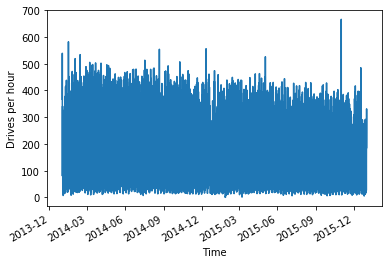

In [180]:
t = pd.read_csv('2014_2015.csv', parse_dates = ['Time']) #, index_col=['month'], parse_dates=['month'])

t = t.set_index('Time')
t.Counts.plot()
plt.ylabel('Drives per hour')
plt.show()

In [181]:
t = pd.read_csv('2014_2015.csv', parse_dates = ['Time'], index_col=0) #, index_col=['month'], parse_dates=['month'])
t.sort_values(by = 'Time', inplace = True)
t.shape

(17519, 3)

We have missing value

In [183]:
t.loc[(t.Time > datetime.datetime(2014, 3, 9, 0, 0)) & (t.Time < datetime.datetime(2014, 3, 9, 6, 0))]

,Counts,Square_id,Time
2139,256.0,1126,2014-03-09 01:00:00
2131,228.0,1126,2014-03-09 03:00:00
2132,135.0,1126,2014-03-09 04:00:00
2128,73.0,1126,2014-03-09 05:00:00


In [184]:
t = t.append(pd.DataFrame({"Counts": [0.5*(t.loc[t.Time == datetime.datetime(2014, 3, 8, 2, 0)].Counts.tolist()[0] + \
                                      t.loc[t.Time == datetime.datetime(2014, 3, 10, 2, 0)].Counts.tolist()[0] )]
                       ,"Square_id": [1126]
                       ,"Time": [datetime.datetime(2014, 3, 9, 2, 0)]})
             , ignore_index=True)
t.sort_values(by = 'Time', inplace = True)

In [185]:
t.loc[(t.Time > datetime.datetime(2014, 3, 9, 0, 0)) & (t.Time < datetime.datetime(2014, 3, 9, 6, 0))]

,Counts,Square_id,Time
1609,256.0,1126,2014-03-09 01:00:00
17519,93.0,1126,2014-03-09 02:00:00
1610,228.0,1126,2014-03-09 03:00:00
1611,135.0,1126,2014-03-09 04:00:00
1612,73.0,1126,2014-03-09 05:00:00


### 1.

Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [186]:
t.head()

,Counts,Square_id,Time
0,367.0,1126,2014-01-01 00:00:00
1,539.0,1126,2014-01-01 01:00:00
2,443.0,1126,2014-01-01 02:00:00
3,372.0,1126,2014-01-01 03:00:00
4,213.0,1126,2014-01-01 04:00:00


In [207]:
K = [2,3,4,5]


for i in range(len(K)):
    t['s' + str(K[i]) + 'w'] = np.sin(((t.index + 1) * 2.0 * i * np.pi)/ 168.0)
    t['c' + str(K[i]) + 'w'] = np.cos(((t.index + 1) * 2.0 * i * np.pi)/ 168.0)
    
    t['s' + str(K[i]) + 'y'] = np.sin(((t.index + 1) * 2.0 * i * np.pi)/ 8760.0)
    t['c' + str(K[i]) + 'y'] = np.cos(((t.index + 1) * 2.0 * i * np.pi)/ 8760.0)
    
t['treand_feature'] = t.index + 1
t.head()

,Counts,Square_id,Time,s2w,c2w,s2y,c2y,s3w,c3w,s3y,c3y,s4w,c4w,s4y,c4y,s5w,c5w,s5y,c5y,treand_feature
0,367.0,1126,2014-01-01 00:00:00,0.0,1.0,0.0,1.0,0.037391,0.999301,0.000717,1.000000,0.074730,0.997204,0.001435,0.999999,0.111964,0.993712,0.002152,0.999998,1
1,539.0,1126,2014-01-01 01:00:00,0.0,1.0,0.0,1.0,0.074730,0.997204,0.001435,0.999999,0.149042,0.988831,0.002869,0.999996,0.222521,0.974928,0.004304,0.999991,2
2,443.0,1126,2014-01-01 02:00:00,0.0,1.0,0.0,1.0,0.111964,0.993712,0.002152,0.999998,0.222521,0.974928,0.004304,0.999991,0.330279,0.943883,0.006455,0.999979,3
3,372.0,1126,2014-01-01 03:00:00,0.0,1.0,0.0,1.0,0.149042,0.988831,0.002869,0.999996,0.294755,0.955573,0.005738,0.999984,0.433884,0.900969,0.008607,0.999963,4
4,213.0,1126,2014-01-01 04:00:00,0.0,1.0,0.0,1.0,0.185912,0.982566,0.003586,0.999994,0.365341,0.930874,0.007173,0.999974,0.532032,0.846724,0.010759,0.999942,5


### 2.

Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [250]:
from sklearn import cross_validation,linear_model, metrics
#создание объекта - классификатора
lr = linear_model.LinearRegression()

Y = t.Counts
cols = ['treand_feature'] + map(lambda x: 's' + str(x) + 'w', K) + map(lambda x: 's' + str(x) + 'y', K)
X = t[cols]

lr.fit(X, Y)
lr_predictions = lr.predict(X)

deltas = Y.tolist() - lr_predictions

In [264]:
ts = pd.DataFrame({"deltas": deltas
                   ,'actuals': Y.tolist()
                   ,'preds': lr_predictions
                  }
                  ,index = t.Time.tolist())
ts.head()

,actuals,deltas,preds
2014-01-01 00:00:00,367.0,136.859357,230.140643
2014-01-01 01:00:00,539.0,308.895985,230.104015
2014-01-01 02:00:00,443.0,212.916061,230.083939
2014-01-01 03:00:00,372.0,141.911572,230.088428
2014-01-01 04:00:00,213.0,-17.125189,230.125189


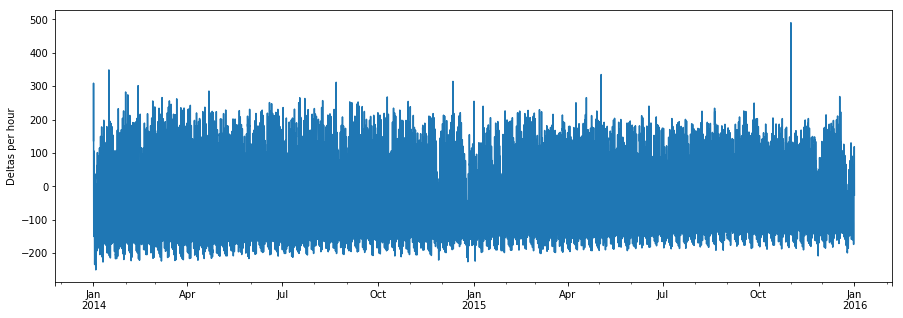

In [265]:
plt.figure(figsize=(15,5))
ts.deltas.plot()
plt.ylabel('Deltas per hour')
plt.show()

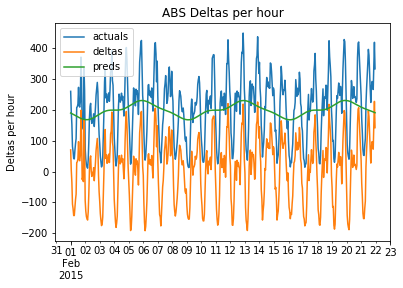

In [420]:
ts.loc[(ts.index >  datetime.datetime(2015, 1, 31, 23, 0)) & (ts.index <  datetime.datetime(2015, 2, 22, 0, 0))
      ,['actuals', 'deltas', 'preds']].plot()
plt.ylabel('Deltas per hour')
plt.title('ABS Deltas per hour')
plt.show()

##### Summary for 2

I can not say that we completely managed get rid of weekly seasonaluty after regreession, but sertain trend is detected

### 3.

Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [267]:
import statsmodels.api as sm

Residuals are might be both positive and negative: let make it positive only

In [268]:
print 'Before transform:', ts.deltas.min()
ts['deltas_positive'] = ts.deltas + abs(ts.deltas.min())*2
print 'After transform:', ts.deltas_positive.min()

Before transform: -250.40948211690068
After transform: 250.40948211690068


In [269]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts.deltas_positive)[1])

Критерий Дики-Фуллера: p=0.000000


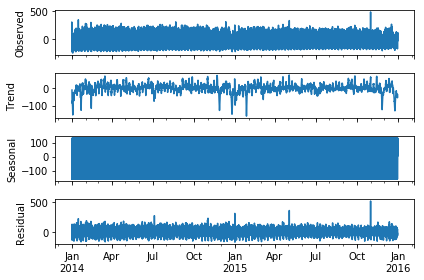

In [270]:
sm.tsa.seasonal_decompose(pd.Series(ts.deltas)).plot()

##### 3.a. Variance unification

In [271]:
ts['deltas_positive_box'], lmbda = stats.boxcox(ts.deltas_positive)
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 1.156653


In [272]:
ts.head()

,actuals,deltas,preds,deltas_positive,deltas_positive_box
2014-01-01 00:00:00,367.0,136.859357,230.140643,637.678322,1515.302313
2014-01-01 01:00:00,539.0,308.895985,230.104015,809.714949,1997.741350
2014-01-01 02:00:00,443.0,212.916061,230.083939,713.735025,1726.357650
2014-01-01 03:00:00,372.0,141.911572,230.088428,642.730536,1529.205004
2014-01-01 04:00:00,213.0,-17.125189,230.125189,483.693775,1100.453214


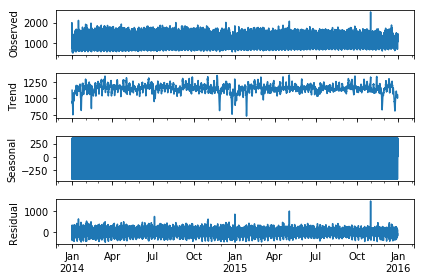

In [273]:
#just in case checked tsa decomposition for converted time series
#not really helpd with residuals being with not stable variance
sm.tsa.seasonal_decompose(ts.deltas_positive_box).plot()

Difficult to say that something was improved - lets go back to positive values

##### 3.b.Time series differentiation

In [276]:
# we start with main differentiation: dialy
ts['deltas_positive_diff24'] = ts.deltas_positive - ts.deltas_positive.shift(24)

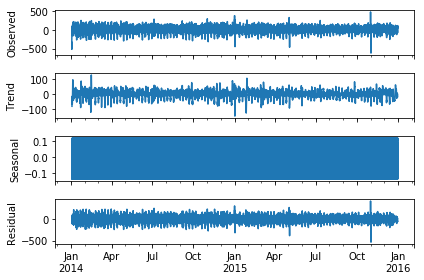

In [277]:
sm.tsa.seasonal_decompose(ts.deltas_positive_diff24[24:]).plot()

In [282]:
# next one is hourly
ts['deltas_positive_diff24_diff1'] = ts.deltas_positive_diff24 - ts.deltas_positive_diff24.shift(1)

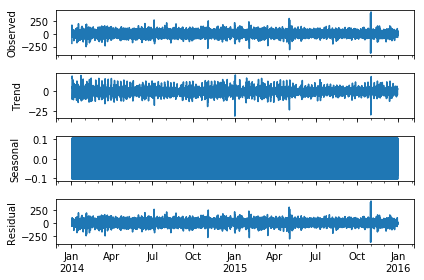

In [283]:
sm.tsa.seasonal_decompose(ts.deltas_positive_diff24_diff1[24+1:]).plot()

##### Summary for 3

I would rather proceed with daily + hourly differentiating.

### 4

Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

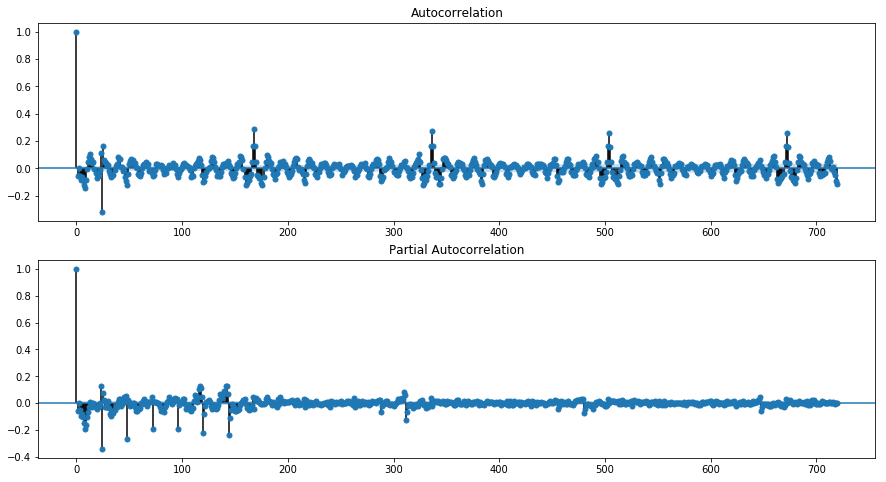

In [309]:
plt.figure(figsize = (15,8))  # notation depends on pyton version!!!!
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ts.deltas_positive_diff24_diff1[24+1:].values.squeeze(), lags=24*30, ax=ax)
#pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ts.deltas_positive_diff24_diff1[24+1:].values.squeeze(), lags=24*30, ax=ax)
#pylab.show()

In [310]:
# Initial parameters based on chart observations: actullay this is not our case, sad ;(
#let do not make the model difficult for that run
Q = 1
q = 1

P = 1
p = 1

In [311]:
ps = range(0, p+1)
d = 1
qs = range(0, q+1)
Ps = range(0, P+1)
D = 1
Qs = range(0, Q+1)

In [312]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [313]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ts.deltas_positive, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 26min 1s


### 5

Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.

In [314]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters            aic
10  (1, 0, 1, 1)  172415.907811
6   (0, 1, 1, 1)  172416.255353
14  (1, 1, 1, 1)  172417.220033
2   (0, 0, 1, 1)  172423.512033
12  (1, 1, 0, 1)  173206.333973


In [315]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    deltas_positive   No. Observations:                17520
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 24)   Log Likelihood              -86203.954
Date:                            Fri, 11 May 2018   AIC                         172415.908
Time:                                    14:40:29   BIC                         172446.992
Sample:                                01-01-2014   HQIC                        172426.143
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0239      0.005      5.269      0.000       0.015       0.033
ar.S.L24       0.2222      0.006   

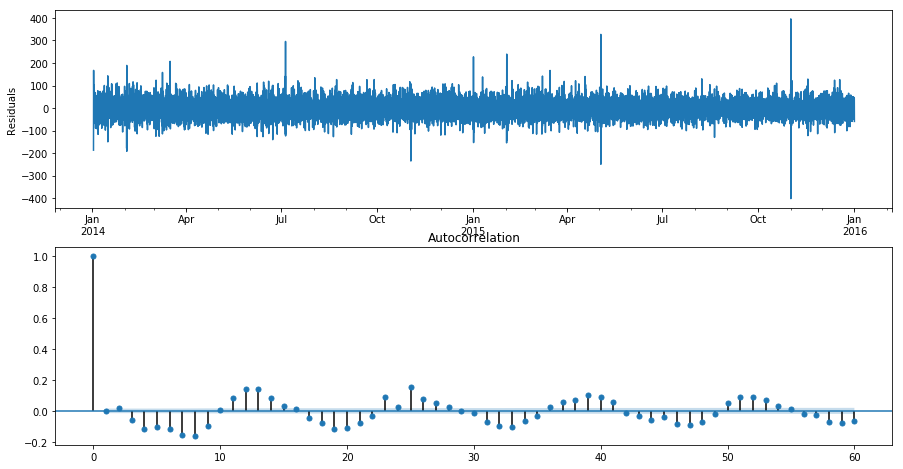

In [319]:
plt.figure(figsize= (15,8)) # notation depends on pyton version!!!!
plt.subplot(211)
best_model.resid[24 + 1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24 + 1:].values.squeeze(), lags=60, ax=ax)



In [370]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])

Критерий Стьюдента: p=0.806452


##### Summary for 5

We still have deviations t-test is accepting H0 (due to time series complexity)

### 6

Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.


In [449]:
ts['delta_positive_model'] = best_model.fittedvalues
ts['best_model_resids'] = best_model.resid
ts['my_foecast'] = ts['delta_positive_model'] - abs(ts.deltas.min())*2 + ts.preds
ts['tmp'] = sm.tsa.seasonal_decompose(ts.deltas_positive_diff24_diff1[24+1:]).Residual

AttributeError: 'DecomposeResult' object has no attribute 'Residual'

In [448]:
ts.head()

,actuals,deltas,preds,deltas_positive,deltas_positive_box,deltas_positive_diff24,deltas_positive_diff24_diff168,deltas_positive_diff24_diff1,delta_positive_model,my_foecast,best_model_resids,deltas_positive_fcst_to_show,tmp
2014-01-01 00:00:00,367.0,136.859357,230.140643,637.678322,1515.302313,NaN,NaN,NaN,0.000000,-270.678322,637.678322,0.000000,NaN
2014-01-01 01:00:00,539.0,308.895985,230.104015,809.714949,1997.741350,NaN,NaN,NaN,637.692049,366.977100,172.022900,637.692049,NaN
2014-01-01 02:00:00,443.0,212.916061,230.083939,713.735025,1726.357650,NaN,NaN,NaN,809.722678,538.987652,-95.987652,809.722678,NaN
2014-01-01 03:00:00,372.0,141.911572,230.088428,642.730536,1529.205004,NaN,NaN,NaN,713.731081,443.000546,-71.000546,713.731081,NaN
2014-01-01 04:00:00,213.0,-17.125189,230.125189,483.693775,1100.453214,NaN,NaN,NaN,642.727387,372.033612,-159.033612,642.727387,NaN


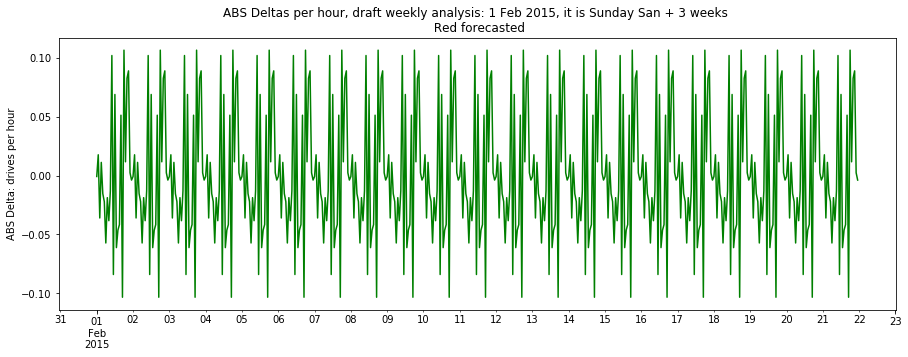

In [445]:
plt.figure(figsize=(15,5))
#ts.loc[(ts_new.index >  datetime.datetime(2015, 1, 31, 23, 0)) & \
#           (ts_new.index <  datetime.datetime(2015, 2, 22, 0, 0))
#          ,].deltas_positive.plot()
#ts.loc[(ts_new.index >  datetime.datetime(2015, 1, 31, 23, 0)) & \
#           (ts_new.index <  datetime.datetime(2015, 2, 22, 0, 0))
#          ,].delta_positive_model.plot(color = 'red')
ts.loc[(ts_new.index >  datetime.datetime(2015, 1, 31, 23, 0)) & \
           (ts_new.index <  datetime.datetime(2015, 2, 22, 0, 0))
          ,].tmp.plot(color = 'green')
plt.ylabel('ABS Delta: drives per hour')
plt.title('ABS Deltas per hour, draft weekly analysis: 1 Feb 2015, it is Sunday San + 3 weeks \n Red forecasted')

plt.show()

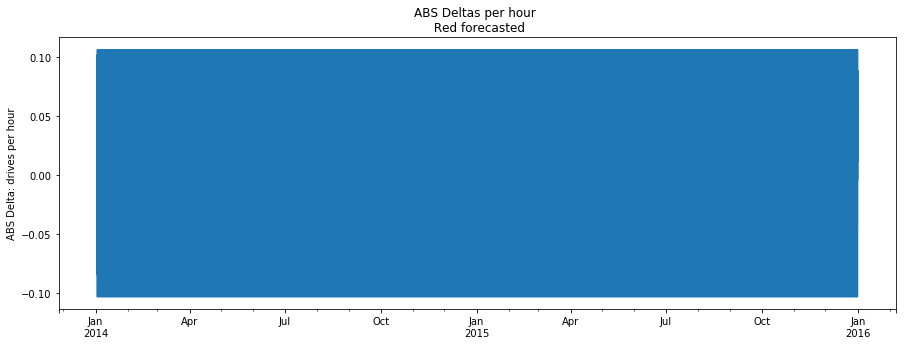

In [446]:
plt.figure(figsize=(15,5))
#ts.deltas_positive.plot()
ts.tmp.plot()
#ts.delta_positive_model.plot(color = 'red')
plt.ylabel('ABS Delta: drives per hour')
plt.title('ABS Deltas per hour \n Red forecasted')
plt.show()

In [378]:
ts[['deltas_positive', 'best_model_resids']].describe()

,deltas_positive,best_model_resids
count,17520.000000,17520.000000
mean,500.818964,0.080665
std,105.920912,33.955997
min,250.409482,-402.198804
25%,414.679694,-20.484215
50%,516.741022,1.297232
75%,573.877314,19.766686
max,990.873406,637.678322


In [421]:
ts.best_model_resids.quantile(q = [0.05,0.1,0.15,0.20,0.25,0.5,0.75,0.8,0.85,0.9,0.95])

0.05   -54.598518
0.10   -41.621176
0.15   -32.578414
0.20   -25.885037
0.25   -20.484215
0.50     1.297232
0.75    19.766686
0.80    24.641362
0.85    30.620362
0.90    38.843318
0.95    52.621768
Name: best_model_resids, dtype: float64

Let define 'Bad' as above 55 residual

In [430]:
ts['deltas_positive_fcst_to_show'] = ts.delta_positive_model
ts.loc[abs(ts.best_model_resids) < 55, 'deltas_positive_fcst_to_show'] = np.nan

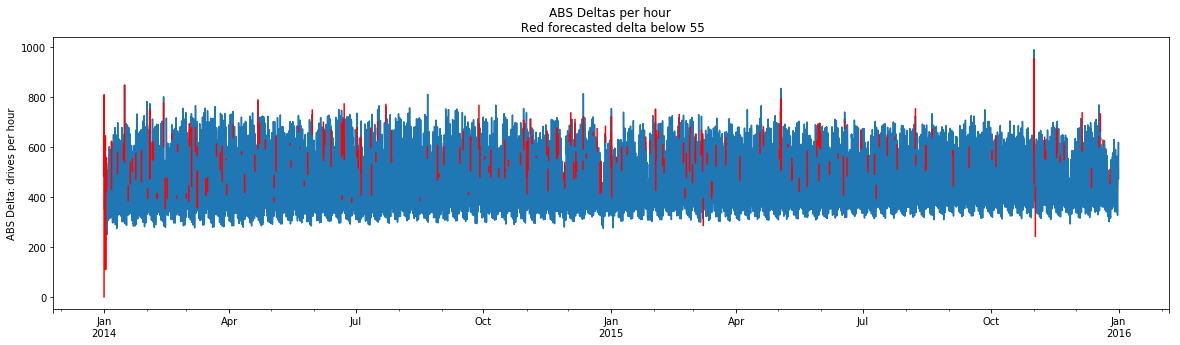

In [431]:
plt.figure(figsize=(20,5))
ts.deltas_positive.plot()
ts.deltas_positive_fcst_to_show.plot(color = 'red')
plt.title('ABS Deltas per hour \n Red forecasted delta error above 55')
plt.ylabel('ABS Delta: drives per hour')
plt.show()

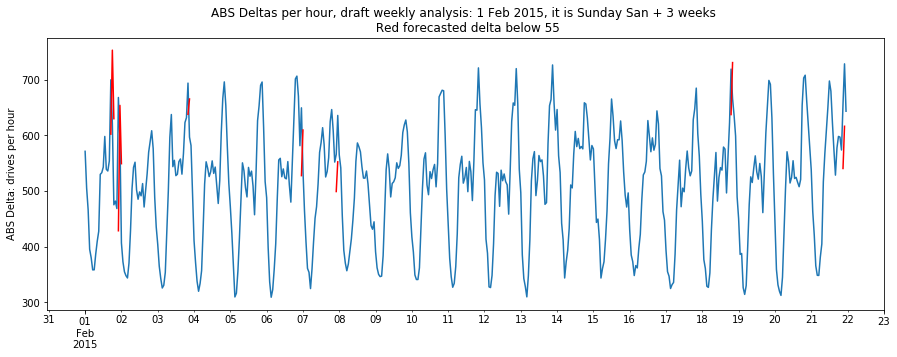

In [432]:
plt.figure(figsize=(15,5))
ts.loc[(ts_new.index >  datetime.datetime(2015, 1, 31, 23, 0)) & \
           (ts_new.index <  datetime.datetime(2015, 2, 22, 0, 0))
          ,].deltas_positive.plot()
ts.loc[(ts_new.index >  datetime.datetime(2015, 1, 31, 23, 0)) & \
           (ts_new.index <  datetime.datetime(2015, 2, 22, 0, 0))
          ,].deltas_positive_fcst_to_show.plot(color = 'red')
plt.title('ABS Deltas per hour, draft weekly analysis: 1 Feb 2015, it is Sunday San + 3 weeks \n Red forecasted delta error above 55')
plt.ylabel('ABS Delta: drives per hour')
plt.show()

The model I got seems to be more or less valid, can not say that it demonstrates systematic error

sm.tsa.seasonal_decompose(ts.deltas_positive_diff24[24:])

In [434]:
sm.tsa.seasonal_decompose(ts.deltas_positive_diff24[24:]).trend

2014-01-02 00:00:00          NaN
2014-01-02 01:00:00          NaN
2014-01-02 02:00:00          NaN
2014-01-02 03:00:00          NaN
2014-01-02 04:00:00          NaN
2014-01-02 05:00:00          NaN
2014-01-02 06:00:00          NaN
2014-01-02 07:00:00          NaN
2014-01-02 08:00:00          NaN
2014-01-02 09:00:00          NaN
2014-01-02 10:00:00          NaN
2014-01-02 11:00:00          NaN
2014-01-02 12:00:00   -83.224213
2014-01-02 13:00:00   -66.610294
2014-01-02 14:00:00   -47.602267
2014-01-02 15:00:00   -31.404979
2014-01-02 16:00:00   -20.016246
2014-01-02 17:00:00   -15.164372
2014-01-02 18:00:00   -15.808156
2014-01-02 19:00:00   -20.699382
2014-01-02 20:00:00   -28.841120
2014-01-02 21:00:00   -38.821026
2014-01-02 22:00:00   -46.394612
2014-01-02 23:00:00   -52.776848
2014-01-03 00:00:00   -59.808747
2014-01-03 01:00:00   -65.519767
2014-01-03 02:00:00   -68.690208
2014-01-03 03:00:00   -67.746936
2014-01-03 04:00:00   -66.554921
2014-01-03 05:00:00   -65.104618
          

In [454]:
? sm.tsa.seasonal_decompose(ts.deltas_positive_diff24_diff1[24+1:])